<a href="https://colab.research.google.com/github/dewiginting123/MachineLearning/blob/main/WEEK%207/NYCT_from_A_to_Z_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Machinelearning/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Machinelearning/test.csv')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [ ]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

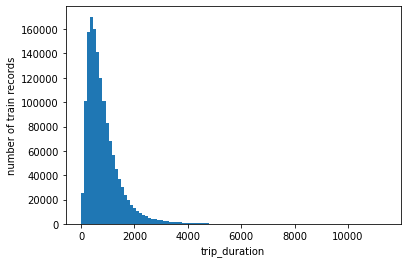

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

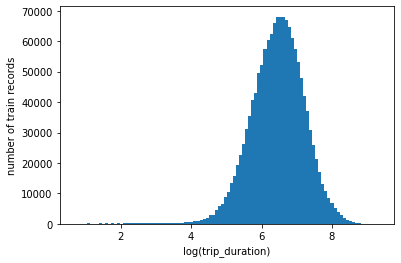

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


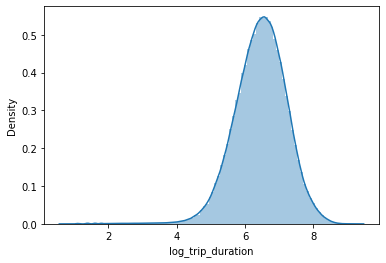

In [ ]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

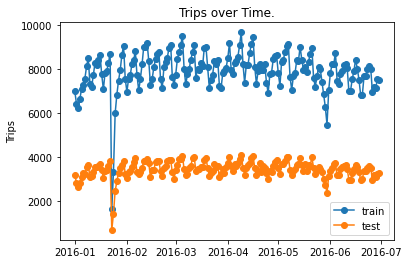

In [ ]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

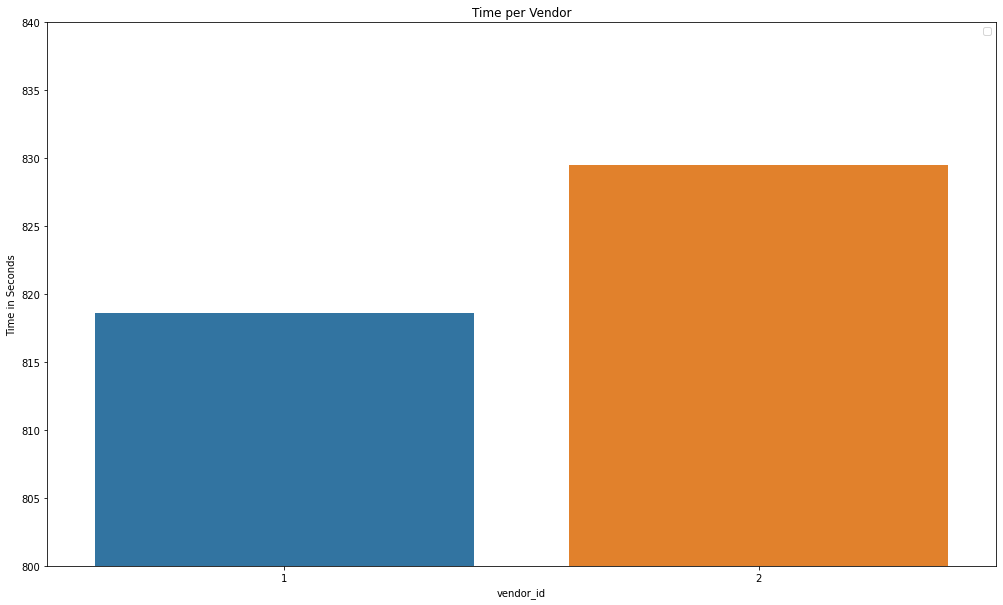

In [ ]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


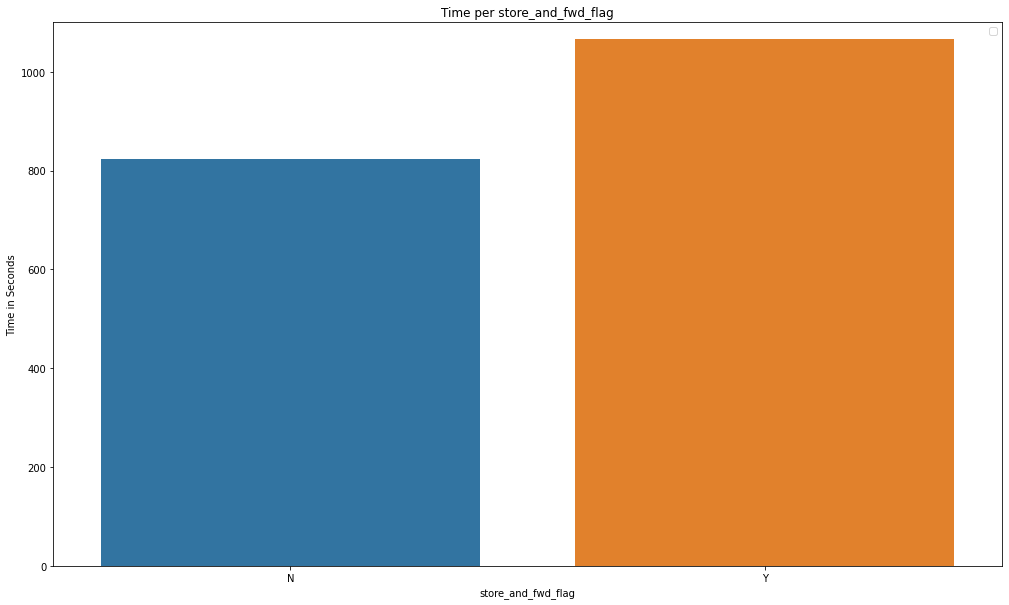

In [ ]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

No handles with labels found to put in legend.


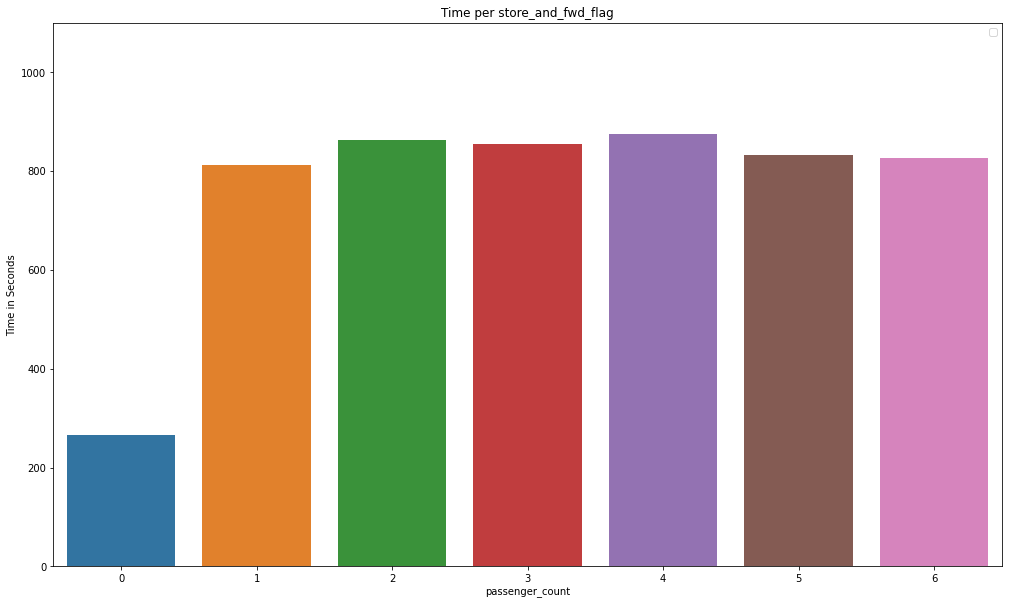

In [ ]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [ ]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [ ]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

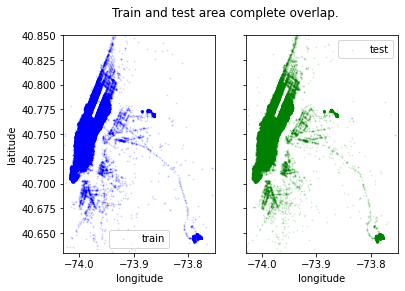

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

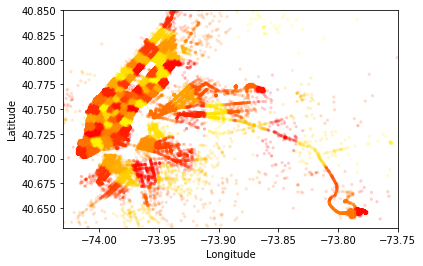

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [ ]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [ ]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [ ]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [ ]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [ ]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

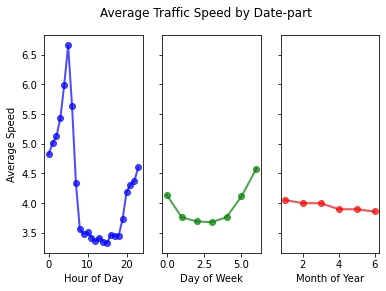

In [ ]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

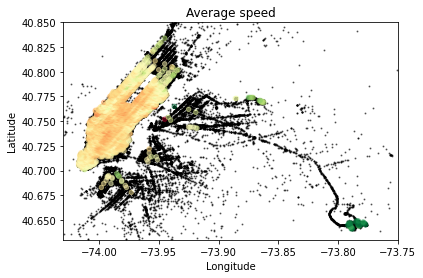

In [ ]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [ ]:
fr1 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('../input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

In [ ]:
train.shape, test.shape

In [ ]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [ ]:
vendor_train.shape,vendor_test.shape

In [ ]:
passenger_count_train.shape,passenger_count_test.shape

In [ ]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

In [ ]:
cluster_pickup_train.shape,cluster_pickup_test.shape

In [ ]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

In [ ]:
month_train.shape,month_test.shape

In [ ]:
dom_train.shape,dom_test.shape

In [ ]:
hour_train.shape,hour_test.shape

In [ ]:
dow_train.shape,dow_test.shape

In [ ]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [ ]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [ ]:
train.shape,test.shape

In [ ]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [ ]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [ ]:
Train_Master.shape,Test_master.shape

In [ ]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [ ]:
Train_Master.shape,Test_master.shape

In [ ]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [ ]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
#md = [6]
#lr = [0.1,0.3]
#mcw = [20,25,30]
#for m in md:
#    for l in lr:
#        for n in mcw:
#            t0 = datetime.now()
#            xgb_pars = {'min_child_weight': mcw, 'eta': lr, 'colsample_bytree': 0.9, 
#                        'max_depth': md,
#            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#            'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10,
#                  maximize=False, verbose_eval=1)

In [ ]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [ ]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [ ]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)